# 1DCNN code for damage localization

## Importing APIs

In [121]:
#imports
import os
#import zipfile
%matplotlib inline
import random 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Conv1D, MaxPooling1D, Dropout, Lambda, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical,plot_model
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import *
from sklearn.preprocessing import MinMaxScaler

## Callbacks

In [226]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_acc')>0.99) and (logs.get('acc')>0.99) and (logs.get('val_loss')<0.07) and (logs.get('loss')<0.07):
      print("\nReached perfect accuracy so cancelling training!")
      self.model.stop_training = True

epoch_schedule = myCallback()

In [227]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 5))

## Importing data

In [267]:
dataset = pd.read_csv("data_1multiclass_balanced_600000.csv") 
dataset.head()

Unnamed: 0.1  Unnamed: 0  num_analysis   t       F_fem           F  \
0        499482      499482        499482  83  117.845623  121.697254   
1        262211      262211        262211  43  265.783152  252.710529   
2        385449      385449        385449  64  399.371977  358.907183   
3        513036      513036        513036  85   97.086090  106.447401   
4        169117      169117        169117  28  355.247139  357.526752   

         d1        d2        d3        d4  ...  label5  label6  alfa1  alfa2  \
0  0.003542  0.005494  0.007458  0.009431  ...       0       0   0.50   1.00   
1  0.004003  0.008160  0.012342  0.016543  ...       0       1   1.00   1.00   
2  0.006014  0.012261  0.018545  0.028415  ...       0       0   1.00   1.00   
3  0.002977  0.004590  0.006211  0.007840  ...       0       0   0.49   1.00   
4  0.005350  0.011964  0.017554  0.023169  ...       0       0   1.00   0.83   

   alfa3  alfa4  alfa5  alfa6  beta  label  
0    1.0   1.00    1.0   1.00   1.0      1  
1    1.0   1.00    1.0   0.74   1.0      1  
2    1.0   0.62    1.0   1.00   1.0      1  
3    1.0   1.00    1.0   1.00   1.0      1  
4    1.0   1.00    1.0   1.00   1.0      1  

[5 rows x 26 columns]

In [268]:
dataset=dataset.drop(['Unnamed: 0.1'], axis=1)
dataset=dataset.drop(['Unnamed: 0'], axis=1)
dataset=dataset.drop(['num_analysis'], axis=1)
dataset=dataset.drop(['F_fem'], axis=1)
dataset=shuffle(dataset)

In [269]:
dataset['F'] = round(dataset['F'],6)
dataset['d1'] = round(dataset['d1'] , 3)
dataset['d2'] = round(dataset['d2'] , 3)
dataset['d3'] = round(dataset['d3'] , 3)
dataset['d4'] = round(dataset['d4'] , 3)
dataset['d5'] = round(dataset['d5'] , 3)
dataset['d6'] = round(dataset['d6'] , 3)
dataset

t           F     d1     d2     d3     d4     d5     d6  label1  \
806779    0  126.415732  0.002  0.004  0.005  0.007  0.009  0.011       0   
1102566   0  211.415840  0.003  0.006  0.009  0.013  0.016  0.019       0   
216297   51  104.840712  0.002  0.003  0.005  0.007  0.009  0.011       0   
186111   10    5.565468  0.000  0.000  0.000  0.000  0.000  0.000       0   
925242    0   26.528393  0.000  0.001  0.001  0.002  0.002  0.002       0   
...      ..         ...    ...    ...    ...    ...    ...    ...     ...   
106996   20    0.511672  0.000  0.000  0.000  0.000  0.000  0.000       0   
145373   53  288.238729  0.005  0.010  0.016  0.021  0.028  0.034       0   
1160121   0   66.116005  0.001  0.002  0.003  0.004  0.005  0.006       0   
161914   80  154.186595  0.002  0.005  0.010  0.012  0.015  0.017       0   
929089    0  190.886834  0.003  0.006  0.009  0.013  0.016  0.019       0   

         label2  ...  label5  label6  alfa1  alfa2  alfa3  alfa4  alfa5  \
806779        0  ...       0       0    1.0    1.0   1.00    1.0   1.00   
1102566       0  ...       0       0    1.0    1.0   1.00    1.0   1.00   
216297        0  ...       0       1    1.0    1.0   1.00    1.0   1.00   
186111        0  ...       0       0    1.0    1.0   0.94    1.0   1.00   
925242        0  ...       0       0    1.0    1.0   1.00    1.0   1.00   
...         ...  ...     ...     ...    ...    ...    ...    ...    ...   
106996        0  ...       0       0    1.0    1.0   0.88    1.0   1.00   
145373        0  ...       1       0    1.0    1.0   1.00    1.0   0.68   
1160121       0  ...       0       0    1.0    1.0   1.00    1.0   1.00   
161914        0  ...       0       0    1.0    1.0   0.52    1.0   1.00   
929089        0  ...       0       0    1.0    1.0   1.00    1.0   1.00   

         alfa6  beta  label  
806779    1.00   1.0      0  
1102566   1.00   1.0      0  
216297    0.69   1.0      1  
186111    1.00   1.0      1  
925242    1.00   1.0      0  
...        ...   ...    ...  
106996    1.00   1.0      1  
145373    1.00   1.0      1  
1160121   1.00   1.0      0  
161914    1.00   1.0      1  
929089    1.00   1.0      0  

[1200000 rows x 22 columns]

In [270]:
dataset=dataset.values
X = dataset[:,[2,3,4,5,6,7]].astype(float)
print(X[0])

[0.002 0.004 0.005 0.007 0.009 0.011]


In [271]:
Y = dataset[:,21]
print(Y[0])

0.0


In [272]:
dataset=shuffle(dataset)

In [273]:
# load DATEST de Test
dataTest = pd.read_excel("datos_TEST.xlsx") 
dataTest= shuffle(dataTest)
dataTest['d1'] = dataTest['d1'] / 1000
dataTest['d2'] = dataTest['d2'] / 1000
dataTest['d3'] = dataTest['d3'] / 1000
dataTest['d4'] = dataTest['d4'] / 1000
dataTest['d5'] = dataTest['d5'] / 1000
dataTest['d6'] = dataTest['d6'] / 1000
dataTest.head()

t           F     d1     d2     d3     d4     d5     d6  label1  \
697    66   36.474147  0.001  0.002  0.002  0.003  0.003  0.004       0   
349     0   87.578443  0.001  0.003  0.004  0.005  0.007  0.008       0   
782    66  224.051811  0.004  0.007  0.014  0.017  0.021  0.025       0   
1283  100    1.645668  0.000  0.000  0.000  0.000  0.000  0.000       0   
314     0  381.993333  0.006  0.012  0.018  0.025  0.031  0.037       0   

      label2  ...  label5  label6  alfa1  alfa2  alfa3  alfa4  alfa5  alfa6  \
697        1  ...       0       0    1.0    0.6    1.0    1.0    1.0    1.0   
349        0  ...       0       0    1.0    1.0    1.0    1.0    1.0    1.0   
782        0  ...       0       0    1.0    1.0    0.6    1.0    1.0    1.0   
1283       0  ...       0       1    1.0    1.0    1.0    1.0    1.0    0.4   
314        0  ...       0       0    1.0    1.0    1.0    1.0    1.0    1.0   

      beta  label  
697      1      1  
349      1      0  
782      1      1  
1283     1      1  
314      1      0  

[5 rows x 22 columns]

In [274]:
dataTest_values = dataTest.values
X_test0 = dataTest_values[:,[2,3,4,5,6,7]] # Fuerza (N) y desp (nm)
y_test0 = dataTest_values[:,21] #t 
print(X_test0[0])
print(y_test0[0])

[0.001 0.002 0.002 0.003 0.003 0.004]
1.0


In [275]:
# Vuelvo al Dataset de Training
dataset = shuffle(dataset)
scaler = MinMaxScaler(feature_range=(0,1))

X_scaled = scaler.fit_transform(X)
X=X_scaled
X_test0 = scaler.transform(X_test0)

rows,columns=X.shape
rows0,columns0=X_test0.shape

X=X.reshape(rows,columns,1)

X_test0=X_test0.reshape(rows0,columns0,1)

# 0 es sano, 1 es daño

In [276]:
print(X[0])

[[0.13333333]
 [0.18181818]
 [0.17241379]
 [0.19444444]
 [0.21428571]
 [0.2244898 ]]


In [277]:
print(Y[0])

0.0


In [278]:
# https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8

## Splitting testing and test set

In [279]:
N=rows
split1=int(0.8*N)
split2=int(0.99*N)


# Split the dataset into training and testing sets
X_train, X_test, X_valid = X[:split1], X[split1:split2], X[split2:]
y_train, y_test, y_valid = Y[:split1], Y[split1:split2], Y[split2:]


In [280]:
print(N)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(X_test0.shape, y_test0.shape)


1200000
(960000, 6, 1) (960000,)
(12000, 6, 1) (12000,)
(228000, 6, 1) (228000,)
(1836, 6, 1) (1836,)


In [281]:
print(y_test)

[0. 0. 0. ... 1. 1. 0.]


## Model Architecture

In [282]:
# define model architecture : 1DCNN-classification
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

Inp = Input(shape=(6,1))
#tf.keras.Input(shape=None,
#Inp = Input(shape=(X.shape[1],1))

x1 = Sequential()

x1 = Conv1D(filters=32, kernel_size=3, input_shape=(6,1))(Inp) #32
#x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=32, kernel_size=3, activation='relu')(x1) #32
#x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=32, kernel_size=2, activation='relu')(x1)
#x1 = MaxPooling1D(pool_size=2)(x1)

#x1 = Conv1D(filters=128, kernel_size=3, activation='relu')(x1)
#x1 = MaxPooling1D(pool_size=2)(x1)

#x1 = Conv1D(filters=256, kernel_size=3, activation='relu')(x1)
#x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Flatten()(x1)

cnn1 = Model(Inp,x1)

In [283]:
from keras.layers import concatenate
#x = concatenate([cnn1.output,cnn2.output])
x = cnn1.output
#---------------------------------
x = Dense(64, activation='relu')((x)) #63
#x = Dense(64, activation='relu')(x) #54
#x = Dense(36, activation='relu')(x) #36
#x = Dense(24, activation='relu')(x) #24
#x = Dense(12, activation='relu')(x) #12
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)
#---------------------------------
model = Model(inputs = Inp, outputs=x)

In [284]:
# summary of the model
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 4, 32)             128       
                                                                 
 conv1d_16 (Conv1D)          (None, 2, 32)             3104      
                                                                 
 conv1d_17 (Conv1D)          (None, 1, 32)             2080      
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0  

In [285]:
#import keras
#keras.utils.plot_model(model, "my_first_model.png")

In [286]:
# Functions for recall, precision and f1 score
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Choose Hyperparameters

In [287]:
# compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['acc', precision_m, recall_m])

## Training

In [288]:
# train the model
bsize = 128 #64, 50
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),  epochs=300, batch_size = bsize, verbose=2, shuffle = True, callbacks = [epoch_schedule])
print("Accuracy in Train:", 'acc')
print("Precision in Train:", 'precision_m')
print("Accuracy in Validation:", 'val_acc')
print("Precision in Validation:", 'val_precision_m')

Epoch 1/300
7500/7500 - 23s - loss: 0.6903 - acc: 0.5195 - precision_m: 0.5185 - recall_m: 0.5926 - val_loss: 0.6876 - val_acc: 0.5268 - val_precision_m: 0.5318 - val_recall_m: 0.5003 - 23s/epoch - 3ms/step
Epoch 2/300
7500/7500 - 22s - loss: 0.6833 - acc: 0.5395 - precision_m: 0.5519 - recall_m: 0.4255 - val_loss: 0.6770 - val_acc: 0.5496 - val_precision_m: 0.5770 - val_recall_m: 0.3969 - 22s/epoch - 3ms/step
Epoch 3/300
7500/7500 - 22s - loss: 0.6671 - acc: 0.5842 - precision_m: 0.6469 - recall_m: 0.3809 - val_loss: 0.6532 - val_acc: 0.6217 - val_precision_m: 0.7408 - val_recall_m: 0.3829 - 22s/epoch - 3ms/step
Epoch 4/300
7500/7500 - 22s - loss: 0.6362 - acc: 0.6496 - precision_m: 0.7831 - recall_m: 0.4142 - val_loss: 0.6140 - val_acc: 0.6870 - val_precision_m: 0.8885 - val_recall_m: 0.4331 - 22s/epoch - 3ms/step
Epoch 5/300
7500/7500 - 22s - loss: 0.5946 - acc: 0.6941 - precision_m: 0.8218 - recall_m: 0.4961 - val_loss: 0.5711 - val_acc: 0.7121 - val_precision_m: 0.8507 - val_recal

Epoch 41/300
7500/7500 - 22s - loss: 0.4152 - acc: 0.7922 - precision_m: 0.9571 - recall_m: 0.6119 - val_loss: 0.4148 - val_acc: 0.7910 - val_precision_m: 0.9579 - val_recall_m: 0.6121 - 22s/epoch - 3ms/step
Epoch 42/300
7500/7500 - 21s - loss: 0.4148 - acc: 0.7924 - precision_m: 0.9570 - recall_m: 0.6123 - val_loss: 0.4148 - val_acc: 0.7912 - val_precision_m: 0.9715 - val_recall_m: 0.6033 - 21s/epoch - 3ms/step
Epoch 43/300
7500/7500 - 2240s - loss: 0.4146 - acc: 0.7922 - precision_m: 0.9579 - recall_m: 0.6113 - val_loss: 0.4144 - val_acc: 0.7928 - val_precision_m: 0.9482 - val_recall_m: 0.6225 - 2240s/epoch - 299ms/step
Epoch 44/300
7500/7500 - 26s - loss: 0.4143 - acc: 0.7925 - precision_m: 0.9579 - recall_m: 0.6121 - val_loss: 0.4139 - val_acc: 0.7915 - val_precision_m: 0.9757 - val_recall_m: 0.6013 - 26s/epoch - 4ms/step
Epoch 45/300
7500/7500 - 22s - loss: 0.4140 - acc: 0.7926 - precision_m: 0.9605 - recall_m: 0.6107 - val_loss: 0.4135 - val_acc: 0.7915 - val_precision_m: 0.9783 

Epoch 81/300
7500/7500 - 22s - loss: 0.4091 - acc: 0.7935 - precision_m: 0.9630 - recall_m: 0.6106 - val_loss: 0.4093 - val_acc: 0.7935 - val_precision_m: 0.9515 - val_recall_m: 0.6219 - 22s/epoch - 3ms/step
Epoch 82/300
7500/7500 - 22s - loss: 0.4091 - acc: 0.7937 - precision_m: 0.9638 - recall_m: 0.6104 - val_loss: 0.4082 - val_acc: 0.7937 - val_precision_m: 0.9566 - val_recall_m: 0.6188 - 22s/epoch - 3ms/step
Epoch 83/300
7500/7500 - 24s - loss: 0.4090 - acc: 0.7935 - precision_m: 0.9636 - recall_m: 0.6101 - val_loss: 0.4089 - val_acc: 0.7917 - val_precision_m: 0.9830 - val_recall_m: 0.5975 - 24s/epoch - 3ms/step
Epoch 84/300
7500/7500 - 21s - loss: 0.4089 - acc: 0.7936 - precision_m: 0.9644 - recall_m: 0.6099 - val_loss: 0.4091 - val_acc: 0.7912 - val_precision_m: 0.9356 - val_recall_m: 0.6292 - 21s/epoch - 3ms/step
Epoch 85/300
7500/7500 - 22s - loss: 0.4088 - acc: 0.7938 - precision_m: 0.9638 - recall_m: 0.6107 - val_loss: 0.4112 - val_acc: 0.7908 - val_precision_m: 0.9807 - val_

Epoch 121/300
7500/7500 - 21s - loss: 0.4070 - acc: 0.7940 - precision_m: 0.9631 - recall_m: 0.6115 - val_loss: 0.4076 - val_acc: 0.7922 - val_precision_m: 0.9808 - val_recall_m: 0.5996 - 21s/epoch - 3ms/step
Epoch 122/300
7500/7500 - 22s - loss: 0.4071 - acc: 0.7939 - precision_m: 0.9626 - recall_m: 0.6115 - val_loss: 0.4083 - val_acc: 0.7913 - val_precision_m: 0.9845 - val_recall_m: 0.5959 - 22s/epoch - 3ms/step
Epoch 123/300
7500/7500 - 24s - loss: 0.4071 - acc: 0.7941 - precision_m: 0.9633 - recall_m: 0.6116 - val_loss: 0.4083 - val_acc: 0.7918 - val_precision_m: 0.9800 - val_recall_m: 0.5993 - 24s/epoch - 3ms/step
Epoch 124/300
7500/7500 - 22s - loss: 0.4068 - acc: 0.7943 - precision_m: 0.9628 - recall_m: 0.6123 - val_loss: 0.4055 - val_acc: 0.7940 - val_precision_m: 0.9743 - val_recall_m: 0.6076 - 22s/epoch - 3ms/step
Epoch 125/300
7500/7500 - 23s - loss: 0.4070 - acc: 0.7942 - precision_m: 0.9623 - recall_m: 0.6123 - val_loss: 0.4078 - val_acc: 0.7916 - val_precision_m: 0.9837 -

Epoch 161/300
7500/7500 - 24s - loss: 0.4061 - acc: 0.7945 - precision_m: 0.9634 - recall_m: 0.6123 - val_loss: 0.4053 - val_acc: 0.7931 - val_precision_m: 0.9614 - val_recall_m: 0.6141 - 24s/epoch - 3ms/step
Epoch 162/300
7500/7500 - 23s - loss: 0.4060 - acc: 0.7946 - precision_m: 0.9618 - recall_m: 0.6135 - val_loss: 0.4056 - val_acc: 0.7923 - val_precision_m: 0.9648 - val_recall_m: 0.6105 - 23s/epoch - 3ms/step
Epoch 163/300
7500/7500 - 24s - loss: 0.4060 - acc: 0.7944 - precision_m: 0.9612 - recall_m: 0.6136 - val_loss: 0.4055 - val_acc: 0.7952 - val_precision_m: 0.9705 - val_recall_m: 0.6124 - 24s/epoch - 3ms/step
Epoch 164/300
7500/7500 - 24s - loss: 0.4059 - acc: 0.7946 - precision_m: 0.9630 - recall_m: 0.6128 - val_loss: 0.4067 - val_acc: 0.7928 - val_precision_m: 0.9699 - val_recall_m: 0.6077 - 24s/epoch - 3ms/step
Epoch 165/300
7500/7500 - 24s - loss: 0.4059 - acc: 0.7945 - precision_m: 0.9622 - recall_m: 0.6132 - val_loss: 0.4057 - val_acc: 0.7933 - val_precision_m: 0.9693 -

Epoch 201/300
7500/7500 - 24s - loss: 0.4051 - acc: 0.7948 - precision_m: 0.9630 - recall_m: 0.6132 - val_loss: 0.4044 - val_acc: 0.7941 - val_precision_m: 0.9783 - val_recall_m: 0.6049 - 24s/epoch - 3ms/step
Epoch 202/300
7500/7500 - 23s - loss: 0.4051 - acc: 0.7949 - precision_m: 0.9615 - recall_m: 0.6143 - val_loss: 0.4082 - val_acc: 0.7909 - val_precision_m: 0.9566 - val_recall_m: 0.6128 - 23s/epoch - 3ms/step
Epoch 203/300
7500/7500 - 24s - loss: 0.4051 - acc: 0.7949 - precision_m: 0.9629 - recall_m: 0.6134 - val_loss: 0.4051 - val_acc: 0.7935 - val_precision_m: 0.9809 - val_recall_m: 0.6021 - 24s/epoch - 3ms/step
Epoch 204/300
7500/7500 - 24s - loss: 0.4051 - acc: 0.7949 - precision_m: 0.9619 - recall_m: 0.6141 - val_loss: 0.4049 - val_acc: 0.7936 - val_precision_m: 0.9801 - val_recall_m: 0.6028 - 24s/epoch - 3ms/step
Epoch 205/300
7500/7500 - 23s - loss: 0.4051 - acc: 0.7950 - precision_m: 0.9632 - recall_m: 0.6136 - val_loss: 0.4044 - val_acc: 0.7941 - val_precision_m: 0.9783 -

Epoch 241/300
7500/7500 - 23s - loss: 0.4047 - acc: 0.7950 - precision_m: 0.9625 - recall_m: 0.6138 - val_loss: 0.4041 - val_acc: 0.7938 - val_precision_m: 0.9794 - val_recall_m: 0.6037 - 23s/epoch - 3ms/step
Epoch 242/300
7500/7500 - 23s - loss: 0.4047 - acc: 0.7949 - precision_m: 0.9627 - recall_m: 0.6136 - val_loss: 0.4061 - val_acc: 0.7923 - val_precision_m: 0.9845 - val_recall_m: 0.5978 - 23s/epoch - 3ms/step
Epoch 243/300
7500/7500 - 23s - loss: 0.4047 - acc: 0.7951 - precision_m: 0.9635 - recall_m: 0.6134 - val_loss: 0.4041 - val_acc: 0.7933 - val_precision_m: 0.9838 - val_recall_m: 0.6002 - 23s/epoch - 3ms/step
Epoch 244/300
7500/7500 - 23s - loss: 0.4047 - acc: 0.7949 - precision_m: 0.9632 - recall_m: 0.6131 - val_loss: 0.4045 - val_acc: 0.7933 - val_precision_m: 0.9831 - val_recall_m: 0.6005 - 23s/epoch - 3ms/step
Epoch 245/300
7500/7500 - 23s - loss: 0.4046 - acc: 0.7949 - precision_m: 0.9626 - recall_m: 0.6136 - val_loss: 0.4044 - val_acc: 0.7941 - val_precision_m: 0.9783 -

Epoch 281/300
7500/7500 - 24s - loss: 0.4045 - acc: 0.7951 - precision_m: 0.9624 - recall_m: 0.6143 - val_loss: 0.4047 - val_acc: 0.7947 - val_precision_m: 0.9750 - val_recall_m: 0.6084 - 24s/epoch - 3ms/step
Epoch 282/300
7500/7500 - 24s - loss: 0.4045 - acc: 0.7948 - precision_m: 0.9628 - recall_m: 0.6133 - val_loss: 0.4050 - val_acc: 0.7920 - val_precision_m: 0.9896 - val_recall_m: 0.5938 - 24s/epoch - 3ms/step
Epoch 283/300
7500/7500 - 23s - loss: 0.4045 - acc: 0.7948 - precision_m: 0.9630 - recall_m: 0.6131 - val_loss: 0.4042 - val_acc: 0.7944 - val_precision_m: 0.9708 - val_recall_m: 0.6106 - 23s/epoch - 3ms/step
Epoch 284/300
7500/7500 - 24s - loss: 0.4044 - acc: 0.7952 - precision_m: 0.9644 - recall_m: 0.6129 - val_loss: 0.4038 - val_acc: 0.7942 - val_precision_m: 0.9683 - val_recall_m: 0.6115 - 24s/epoch - 3ms/step
Epoch 285/300
7500/7500 - 23s - loss: 0.4046 - acc: 0.7950 - precision_m: 0.9627 - recall_m: 0.6139 - val_loss: 0.4042 - val_acc: 0.7935 - val_precision_m: 0.9809 -

## Plot Accuracy and Loss

In [289]:
print("Accuracy in Train:", round(history.history['acc'][-1], 3))
print("Precision in Train:", round(history.history['precision_m'][-1],3))
print("Recall in Train:", round(history.history['recall_m'][-1],3))
print("Accuracy in Validation:", round(history.history['val_acc'][-1],3))
print("Precision in Validation:", round(history.history['val_precision_m'][-1],3))
print("Recall in Validation:", round(history.history['val_recall_m'][-1],3))


Accuracy in Train: 0.795
Precision in Train: 0.965
Recall in Train: 0.613
Accuracy in Validation: 0.793
Precision in Validation: 0.953
Recall in Validation: 0.619


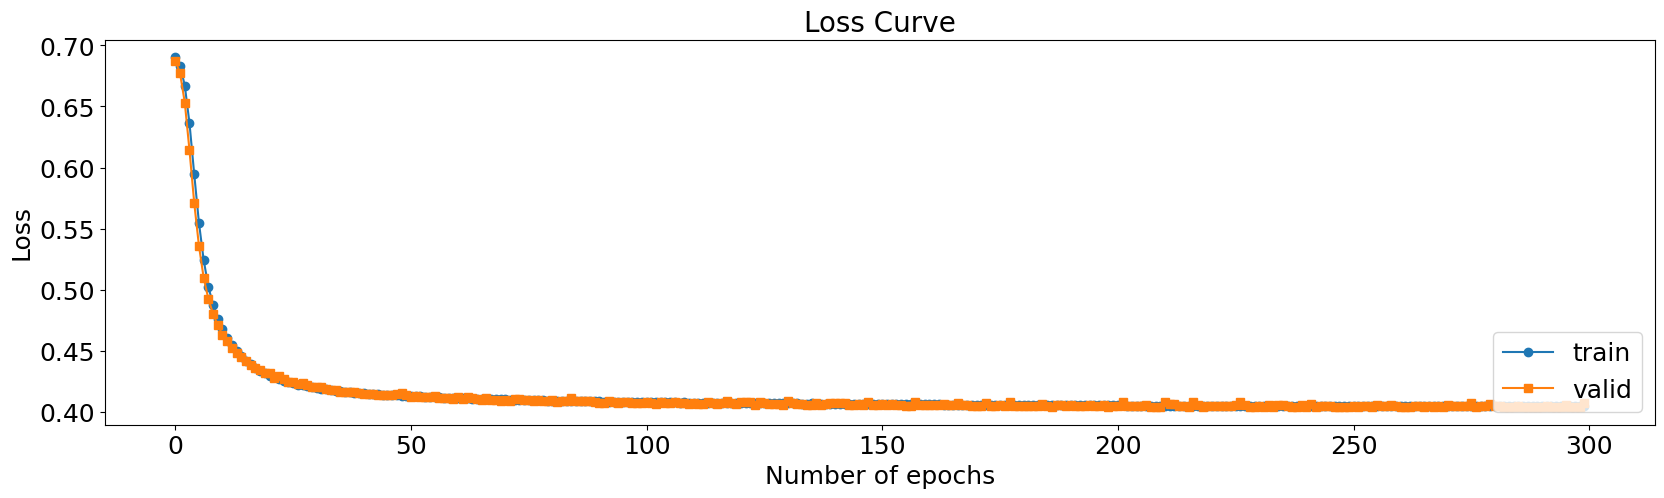

In [290]:
#---Summarize history for loss
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'],'-o')
plt.plot(history.history['val_loss'],'-s')
plt.title('Loss Curve',fontsize=20)
plt.ylabel('Loss',fontsize=18)
#plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'valid'], loc='lower right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()

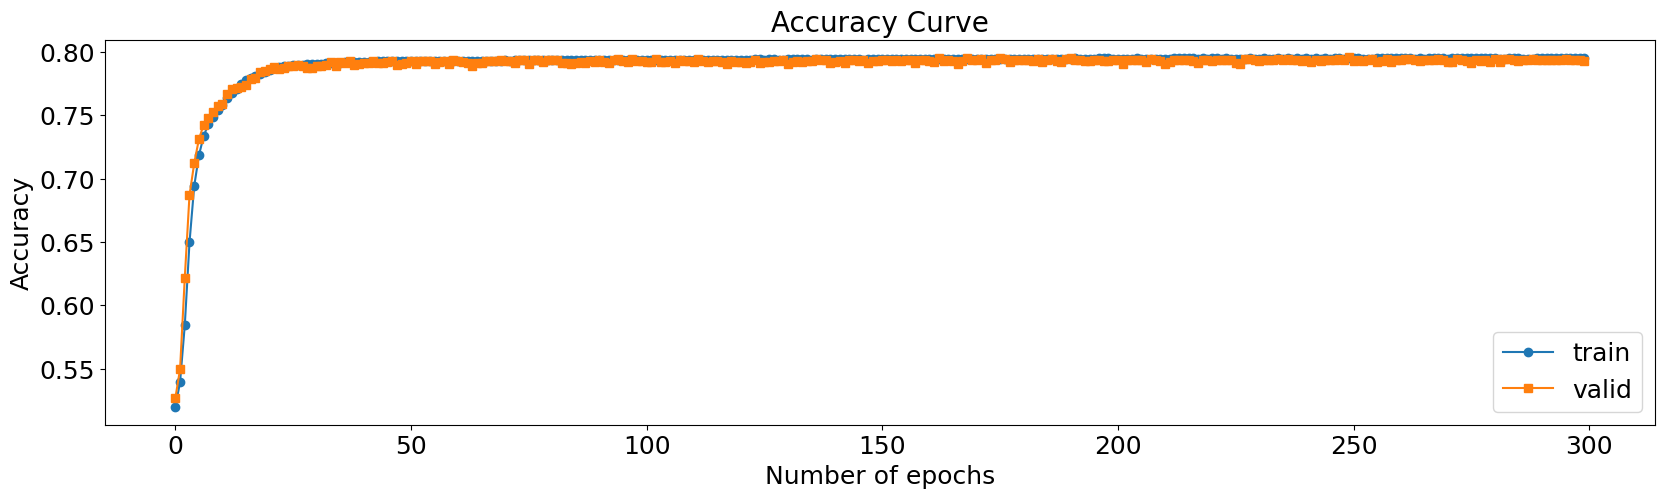

In [291]:
#---Summarize history for accuracy---
plt.figure(figsize=(20,5))
plt.plot(history.history['acc'],'-o')
plt.plot(history.history['val_acc'],'-s')
plt.title('Accuracy Curve',fontsize=20)
plt.ylabel('Accuracy',fontsize=18)
#plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'valid'], loc='lower right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()

### Predictions

In [349]:
from sklearn.utils.multiclass import unique_labels
import itertools
import matplotlib.pyplot as plt
from keras.utils import to_categorical

fig = plt.gcf()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i,j],
      horizontalalignment = 'center',
      color = "white" if cm[i,j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')

<Figure size 640x480 with 0 Axes>

In [350]:
y_predicted = model.predict(X_test, verbose = 2)
y_actual = y_test

y_predict = np.round(y_predicted)
y_act = y_actual

cm = confusion_matrix(y_act, y_predict)

7125/7125 - 11s - 11s/epoch - 1ms/step


In [338]:
[print(value) for value in y_train]

0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0


1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0


0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0


1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0


1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0


1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Confusion matrix, without normalization
[[110182   3709]
 [ 43436  70673]]


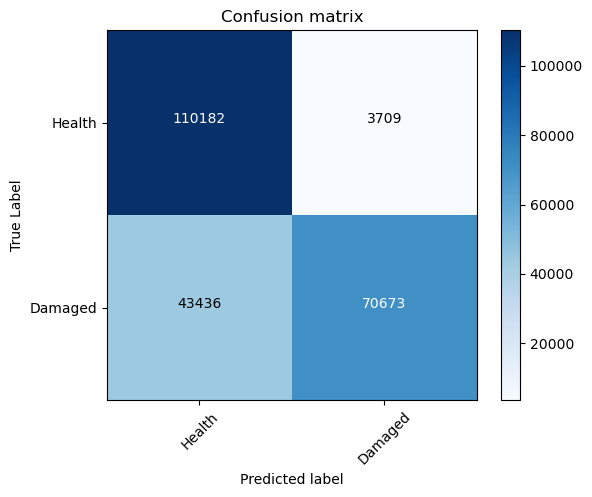

In [339]:
cm = confusion_matrix(y_actual, y_predict)
cm_labels = ['Health','Damaged'] #ATENCION PONER HEALTH PRIMERO, QUE NO ENTIENDE (HEALTH='0')
plot_confusion_matrix(cm, classes=cm_labels, title='Confusion matrix')

Normalized confusion matrix
[[0.97 0.03]
 [0.38 0.62]]


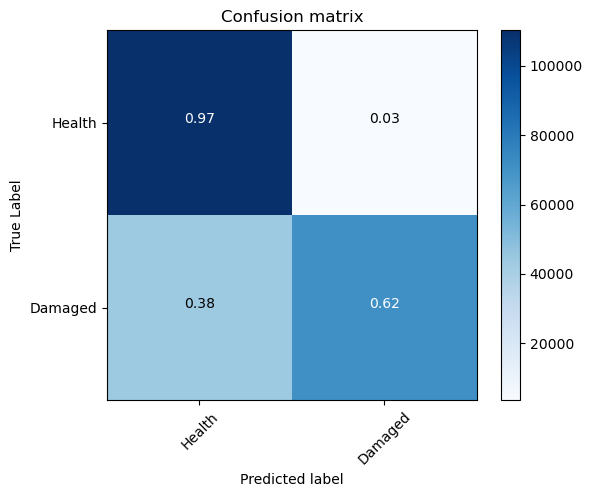

In [340]:
# Plot Normalized confusion matrix
plot_confusion_matrix(cm, classes=cm_labels, normalize = True, title='Confusion matrix')

In [341]:
# Classification Report
print('Classification Report:')
print(classification_report(y_act, y_predict, target_names = cm_labels))
#ATENCION: TIENE CAMBIADOS LOS LETREROS DE PRECISION Y RECALL, PRECISION ES EL SEGUNDO VALOR

Classification Report:
              precision    recall  f1-score   support

      Health       0.72      0.97      0.82    113891
     Damaged       0.95      0.62      0.75    114109

    accuracy                           0.79    228000
   macro avg       0.83      0.79      0.79    228000
weighted avg       0.83      0.79      0.79    228000



### AUC-ROC curve

In [351]:
y_actual.shape

(228000,)

In [352]:
y_actual = np.expand_dims(y_actual, axis=1)
y_actual.shape

(228000, 1)

In [353]:
y_predicted.shape

(228000, 1)

In [355]:
n_classes = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    print(y_actual[:, i])

[0. 0. 0. ... 1. 1. 0.]


In [356]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

n_classes = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_actual[:, i], np.round(y_predicted[:,i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

In [357]:
print(fpr)

{0: array([0.        , 0.03256623, 1.        ])}


In [358]:
print(tpr)

{0: array([0.        , 0.61934641, 1.        ])}


In [359]:
print(roc_auc)

{0: 0.7933900943957919}


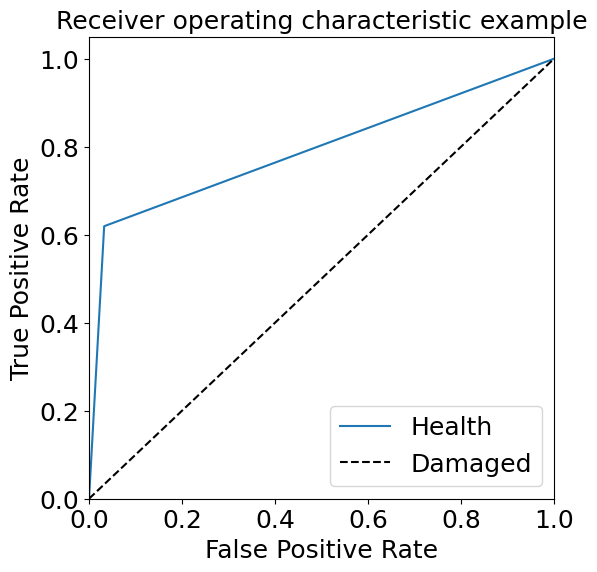

In [360]:
# Plot of a ROC curve for all classes
plt.figure(figsize=(6,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver operating characteristic example',fontsize=18)
    plt.legend(cm_labels,loc="lower right",fontsize=18)

In [303]:
y_predicted0 = model.predict(X_test0, verbose = 2)
y_actual0 = y_test0

y_predict0 = np.round(y_predicted0)
y_act0 = y_actual0

cm = confusion_matrix(y_act0, y_predict0)

58/58 - 0s - 161ms/epoch - 3ms/step


Confusion matrix, without normalization
[[ 612   24]
 [ 139 1061]]


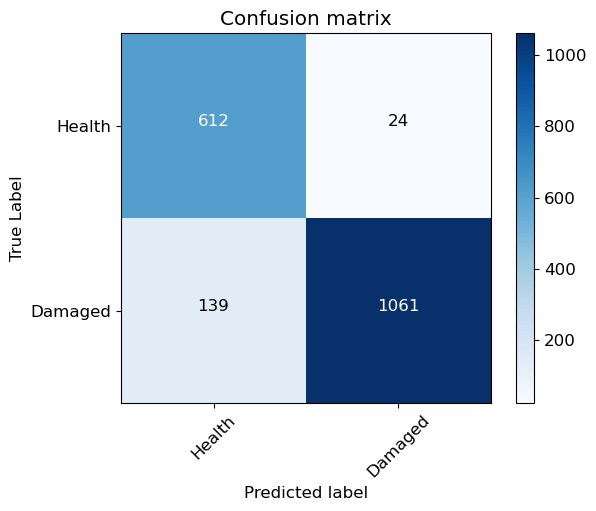

In [367]:
cm = confusion_matrix(y_actual0, y_predict0)
cm_labels = ['Health','Damaged'] #ATENCION PONER HEALTH PRIMERO, QUE NO ENTIENDE (HEALTH='0')
plot_confusion_matrix(cm, classes=cm_labels, title='Confusion matrix')

Normalized confusion matrix
[[0.96 0.04]
 [0.12 0.88]]


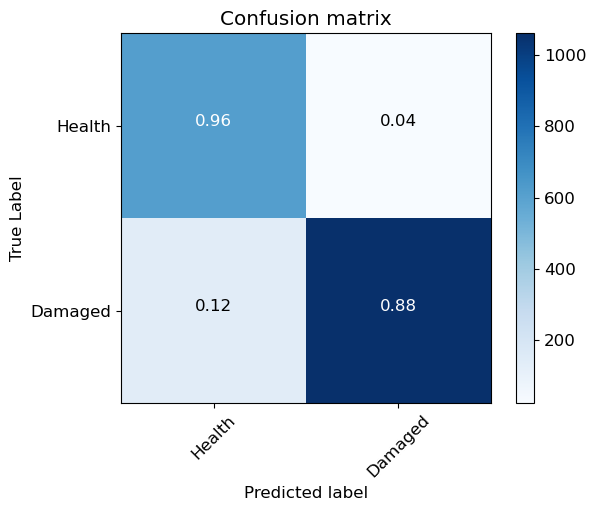

In [368]:
# Plot Normalized confusion matrix
# Increase font size
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(cm, classes=cm_labels, normalize = True, title='Confusion matrix')

In [306]:
# Classification Report
print('Classification Report:')
print(classification_report(y_act0, y_predict0, target_names = cm_labels))
#ATENCION: TIENE CAMBIADOS LOS LETREROS DE PRECISION Y RECALL, PRECISION ES EL SEGUNDO VALOR

Classification Report:
              precision    recall  f1-score   support

      Health       0.81      0.96      0.88       636
     Damaged       0.98      0.88      0.93      1200

    accuracy                           0.91      1836
   macro avg       0.90      0.92      0.91      1836
weighted avg       0.92      0.91      0.91      1836



In [361]:
y_actual0 = np.expand_dims(y_actual0, axis=1)

In [363]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

n_classes = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_actual0[:, i], np.round(y_predicted0[:,i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

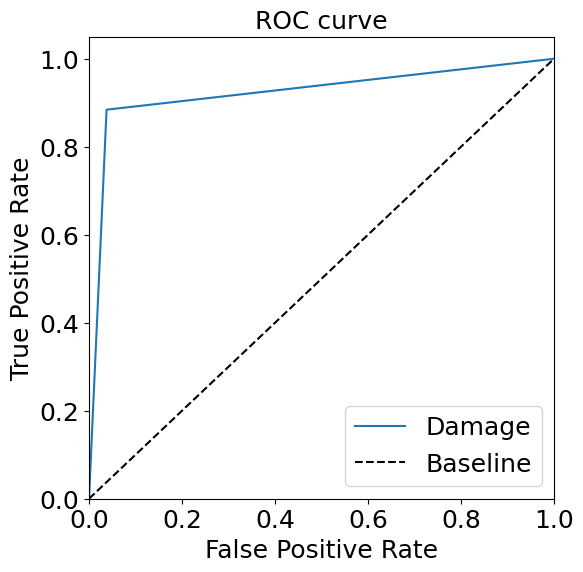

In [407]:
# Plot of a ROC curve for all classes
plt.figure(figsize=(6,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('ROC curve',fontsize=18)
    cm_labels = ['Damage','Baseline']
    plt.legend(cm_labels,loc="lower right",fontsize=18)

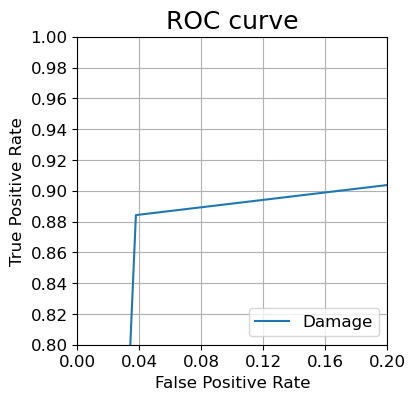

In [406]:
# Plot of a ROC curve for all classes
plt.figure(figsize=(4,4))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    #plt.plot([0, 0.2], [0.8, 1.0], 'k--')
    plt.xlim([0.0, 0.2])
    plt.ylim([0.8, 1.0])
     
    plt.xticks(np.arange(0, 0.21, step=0.04),fontsize=12)
    plt.yticks(np.arange(0.8, 1.01, step=0.02), fontsize=12)
        
    plt.grid(True)
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('ROC curve',fontsize=18)
    cm_labels = ['Damage','Baseline']
    plt.legend(cm_labels,loc="lower right",fontsize=12)